In [3]:
#!pip install vitaldb
#!pip install imbalanced-learn


In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import vitaldb
import warnings
import imblearn
warnings.filterwarnings('ignore')

In [ ]:
liste_ids = pd.read_excel("liste id.xlsx")
liste_ids

,Caseid
0,17
1,19
2,25
3,29
4,34
...,...
543,6346
544,6351
545,6355
546,6378


In [ ]:
df_trks = pd.read_csv('https://api.vitaldb.net/trks')
df_cases = pd.read_csv("https://api.vitaldb.net/cases")

In [ ]:
LSTM_NODES = 16  # Number of cells in LSTM

In [ ]:
MINUTES_AHEAD = 1  # Predict hypotension 1 minutes ahead
BATCH_SIZE = 256  # Batch size for learning
MAX_CASES = 100  # Maximum number of cases for this example
SRATE = 2  # sampling rate for the arterial waveform signal

# Final dataset for training and testing the model
x = []  # input with shape of (segements, timepoints)
y = []  # output with shape of (segments)
valid_mask = []  # validity of each segement
c = []  # caseid of each segment
x1=[]
# maximum number of cases
for caseid in liste_ids['Caseid'].tolist()[0:10]:
    print(f'loading {caseid}', end='...', flush=True)

    # read the arterial waveform
    arts = vitaldb.load_case(caseid, ['Solar8000/ART_MBP'], 2)
    plet = vitaldb.load_case(caseid, ['SNUADC/PLETH'], 2)
    hr = vitaldb.load_case(caseid, ['Solar8000/PLETH_HR'], 2)

    arts[arts<30]=np.nan
    case_valid_mask = ~np.isnan(arts)
    arts = arts[(np.cumsum(case_valid_mask) > 0) & (np.cumsum(case_valid_mask[::-1])[::-1] > 0)]
    
    #Filtering artifacts
    arts=arts[(arts>=20) & (arts <=180)].flatten()
    hr=hr[(hr>=30) & (hr <=160)].flatten()
    plet=plet[(plet>=-10) & (plet<=100)].flatten()



    case_sample = 0
    case_event = 0

    for i in range(0, len(arts) - SRATE * (20 + (1 + MINUTES_AHEAD) * 60), 10 * SRATE):
        segx = arts[i:i + SRATE * 20]
        segy = arts[i + SRATE * (20 + MINUTES_AHEAD * 60):i + SRATE * (20 + (MINUTES_AHEAD + 1) * 60)]
        seg2x = plet[i:i + SRATE * 20]
        seg2y = plet[i + SRATE * (20 + MINUTES_AHEAD * 60):i + SRATE * (20 + (MINUTES_AHEAD + 1) * 60)]
        seg3x=hr[i:i + SRATE * 20]
        seg3y = hr[i + SRATE * (20 + MINUTES_AHEAD * 60):i + SRATE * (20 + (MINUTES_AHEAD + 1) * 60)]

        # check the validity of this segment
        valid = True
        if np.isnan(segx).mean() > 0.1:
            valid = False
        if np.isnan(segy).mean() > 0.1:
            valid = False
        elif (segx > 150).any():
            valid = False
        elif (segy > 150).any():
            valid = False
        elif (np.abs(np.diff(segx)) > 50).any():  # abrupt change -> noise
            valid = False
        elif (np.abs(np.diff(segy)) > 50).any():  # abrupt change -> noise
            valid = False


        # 2 sec moving avg
        n = 2 * SRATE
        segy = np.nancumsum(segy, dtype=np.float32)
        segy[n:] = segy[n:] - segy[:-n]
        segy = segy[n - 1:] / n

        evt = np.nanmax(segy) < 65
        
        
        x.append(seg2x)
        y.append(evt)
        valid_mask.append(valid)
        c.append(caseid)

        if valid:
            case_sample += 1
            if evt:
                case_event += 1
      

    if case_sample > 0:
        print("{} samples {} ({:.1f} %) events".format(case_sample, case_event, 100 * case_event / case_sample))
    else:
        print('no sample')

    #if len(np.unique(c)) >= MAX_CASES:
    #    break

# final caseids
caseids = np.unique(c)

# convert lists to numpy array



x = np.array(x)
y = np.array(y)
valid_mask = np.array(valid_mask)
c = np.array(c)

# forward filling
x = pd.DataFrame(x).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

# normalization
x -= 65
x /= 65

# add axis for CNN
x = x[...,None]

print(x.shape)
print(y.shape)

print(y.astype(int).sum())

loading 17...

434 samples 8 (1.8 %) events
loading 19...604 samples 93 (15.4 %) events
loading 25...296 samples 12 (4.1 %) events
loading 29...457 samples 0 (0.0 %) events
loading 34...441 samples 0 (0.0 %) events
loading 52...344 samples 5 (1.5 %) events
loading 60...277 samples 1 (0.4 %) events
loading 70...252 samples 0 (0.0 %) events
loading 83...263 samples 3 (1.1 %) events
loading 94...518 samples 44 (8.5 %) events
(4382, 40, 1)
(4382,)
169


In [9]:
# Load the numpy file
datax = np.load('x.npy',allow_pickle=True)
datay = np.load('y.npy',allow_pickle=True)
# Access the data
print(datax.shape)
print(datax[0][0][0].shape)
print(datay.shape)

(201398, 1, 1)
(40,)
(201398,)


In [13]:
new_data_x=[]

# Iterate through the nested arrays and keep track of indices
indices=[]
for i, arr1 in enumerate(datax):
    for j, arr2 in enumerate(arr1):
        for k, item in enumerate(arr2):
            if item.shape == (40,):
                new_data_x.append(item)
            else:
                indices.append(i)

#Converting list to array
new_x=np.array(new_data_x)
new_y = np.delete(datay, indices)

#add axis
print(new_x.shape)
print(new_y.shape)

(200353, 40)
(200353,)


In [20]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, Y_resampled = smote.fit_resample(new_x, new_y)

train_x_valid, test_x_valid, train_y_valid, test_y_valid = train_test_split(X_resampled, 
                                                                            Y_resampled, 
                                                                            test_size=0.2, 
                                                                            random_state=42,
                                                                            stratify=Y_resampled)



In [21]:
# add axis for CNN
train_x_valid = train_x_valid[...,None]  
# add axis for CNN
test_x_valid = test_x_valid[...,None]  

In [22]:
train_y_valid=train_y_valid.astype(int)

In [23]:
train_y_valid.shape

(311660,)

In [24]:
train_x_valid.shape

(311660, 40, 1)

In [50]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, LSTM, Input, BatchNormalization, Bidirectional, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from keras.optimizers import Adam 

LSTM_NODES = 128
BATCH_SIZE = 256

# making output folder
tempdir = 'output'
if not os.path.exists(tempdir):
    os.mkdir(tempdir)
weight_path = tempdir + "/weights.keras"

# build a model
model = Sequential()
model.add(LSTM(LSTM_NODES,
               return_sequences=True, 
               input_shape=train_x_valid.shape[1:]))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=64))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))


# Initialize the model
# model = Sequential()
# # Add an LSTM layer with more units and return_sequences=True for sequence output
# model.add(LSTM(units=128, 
#                return_sequences=True, 
#                #input_shape=train_x_valid.shape[1:]
#                ))
# # Add another LSTM layer with more units and return_sequences=True
# model.add(LSTM(units=64, return_sequences=True))
# # Add a Bidirectional LSTM layer for more complex learning
# model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
# # Add a dropout layer for regularization
# model.add(Dropout(0.5))
# # Add a Dense layer for final output
# model.add(Dense(units=1, activation='sigmoid'))



model.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=1e-3), 
              metrics=['accuracy', 
                       tf.keras.metrics.AUC()])

hist = model.fit(train_x_valid, 
                 train_y_valid, 
                 validation_split=0.3, 
                 epochs=50, 
                 batch_size=BATCH_SIZE,
                 callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
                            ])

# reload the best model
model.load_weights(weight_path)
open(tempdir + "/model.json", "wt").write(model.to_json())

Epoch 1/50
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5877 - auc_9: 0.6188 - loss: 0.6736
Epoch 1: val_loss improved from inf to 1.60034, saving model to output/weights.keras
853/853 ━━━━━━━━━━━━━━━━━━━━ 187s 213ms/step - accuracy: 0.5877 - auc_9: 0.6188 - loss: 0.6736 - val_accuracy: 0.4992 - val_auc_9: 0.6209 - val_loss: 1.6003
Epoch 2/50
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.5970 - auc_9: 0.6348 - loss: 0.6647
Epoch 2: val_loss improved from 1.60034 to 0.69485, saving model to output/weights.keras
853/853 ━━━━━━━━━━━━━━━━━━━━ 173s 203ms/step - accuracy: 0.5970 - auc_9: 0.6348 - loss: 0.6647 - val_accuracy: 0.5435 - val_auc_9: 0.6377 - val_loss: 0.6948
Epoch 3/50
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.5978 - auc_9: 0.6382 - loss: 0.6630
Epoch 3: val_loss did not improve from 0.69485
853/853 ━━━━━━━━━━━━━━━━━━━━ 179s 209ms/step - accuracy: 0.5978 - auc_9: 0.6382 - loss: 0.6630 - val_accuracy: 0.4992 - val_auc_9: 0.6386 - val_loss: 1.2

6217

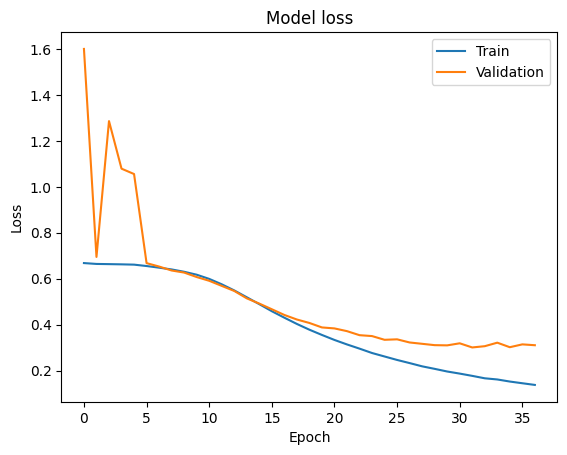

In [51]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('{}/loss_plot.png'.format(tempdir))
plt.show()


In [52]:
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve

# make prediction on the test dataset
test_y_pred = model.predict(test_x_valid).flatten()

precision, recall, thmbps = precision_recall_curve(test_y_valid, test_y_pred)
auprc = auc(recall, precision)

fpr, tpr, thmbps = roc_curve(test_y_valid, test_y_pred)
auroc = auc(fpr, tpr)

thval = 0.5
f1 = f1_score(test_y_valid, test_y_pred > thval)
acc = accuracy_score(test_y_valid, test_y_pred > thval)
tn, fp, fn, tp = confusion_matrix(test_y_valid, test_y_pred > thval).ravel()

testres = 'auroc={:.3f}, auprc={:.3f} acc={:.3f}, F1={:.3f}, PPV={:.1f}, NPV={:.1f}, TN={}, fp={}, fn={}, TP={}'.format(auroc, auprc, acc, f1, tp/(tp+fp)*100, tn/(tn+fn)*100, tn, fp, fn, tp)
print(testres)

# auroc curve
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('{}/auroc.png'.format(tempdir))
plt.close()

# auprc curve
plt.figure(figsize=(10, 10))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('{}/auprc.png'.format(tempdir))
plt.close()

2435/2435 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step
auroc=0.949, auprc=0.936 acc=0.887, F1=0.890, PPV=86.7, NPV=90.9, TN=33493, fp=5465, fn=3347, TP=35611


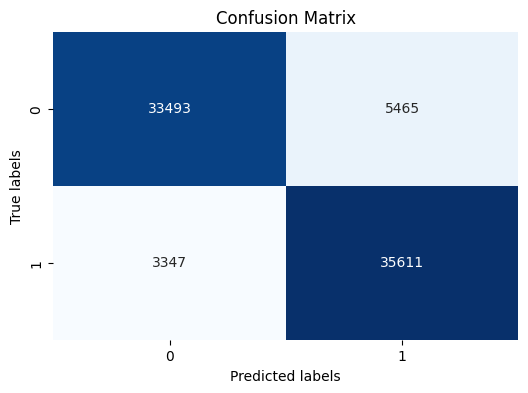

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have calculated the confusion matrix
conf_matrix = confusion_matrix(test_y_valid, test_y_pred > thval)

# Visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('{}/confusion_matrix.png'.format(tempdir))
plt.show()
